In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
start_date='01/01/2020'
end_date='04/16/2020'

source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=[
'wealth_index',
'population_density',
]

day=list(range(8,20))
night=list(range(8))+list(range(20,24))

path_to_data='/scratch/spf248/covid/data'

In [3]:
def clean_dates(df,start_date=start_date,end_date=end_date):
    currentYear = datetime.now().year
    df['keep_date']=df.date.apply(lambda x:int(x.split('-')[0])==currentYear)
    df=df[df.keep_date==True].copy()
    df.drop('keep_date',1,inplace=True)
    df.date=pd.to_datetime(df.date)
    df=df[(df['date']>=pd.to_datetime(start_date))&(df['date']<=pd.to_datetime(end_date))].copy()
    return df

def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

# Users Activity Over Time

In [4]:
print('Import Parquet Files')
start = timer()

data_dir = Path(os.path.join(path_to_data,source,'processed',country,'device_id'))
device_id = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

print("Done in", round(timer()-start), "sec")  

Import Parquet Files
Done in 8 sec


In [5]:
print('Import Parquet Files')
start = timer()

data_dir = Path(os.path.join(path_to_data,source,'processed',country,'n_pings_id_date_hour'))
n_pings_id_date_hour = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

print("Done in", round(timer()-start), "sec")  

Import Parquet Files
Done in 45 sec


In [6]:
print('Process data')
start = timer()

n_pings_id_date_hour=clean_dates(n_pings_id_date_hour)
n_pings_n_users_date=n_pings_id_date_hour.groupby('date').agg({'cuebiq_id':'nunique','n_pings':'sum'})

print("Done in", round(timer()-start), "sec")

Process data
Done in 208 sec


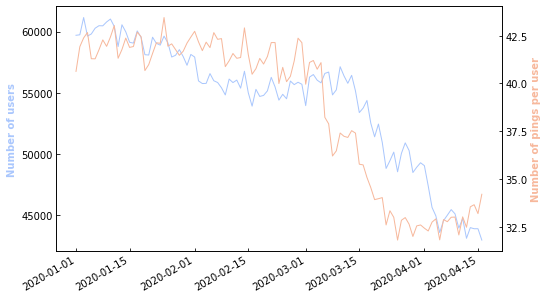

In [7]:
fig,ax1=plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

data1=n_pings_n_users_date['cuebiq_id'].truncate(after=end_date)
ax1.plot(data1.index,data1.values,linewidth=1,color=sns.color_palette("coolwarm", 2)[0])
data2=n_pings_n_users_date['n_pings'].divide(n_pings_n_users_date['cuebiq_id']).truncate(after=end_date)
ax2.plot(data2.index,data2.values,linewidth=1,color=sns.color_palette("coolwarm", 2)[1])

ax1.tick_params(which='both',direction='in',pad=3)
ax2.tick_params(which='both',direction='in',pad=3)
ax1.locator_params(axis='y',nbins=6)
ax2.locator_params(axis='y',nbins=6)

ax1.set_xlabel('')
ax1.set_ylabel('Number of users',fontweight='bold',color=sns.color_palette("coolwarm", 2)[0])
ax2.set_ylabel('Number of pings per user',fontweight='bold',color=sns.color_palette("coolwarm", 2)[1])
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'activity-per-day.pdf'),bbox_inches='tight')

We observe a decrease in the number of active users and number of pings per users over time. 

This pattern is probably resulting from the fact that people staying at home in higher number are more rarely using any geolocation services on their phone.

# Home Presence

In [8]:
print('Import Parquet Files')
start = timer()

data_dir = Path(os.path.join(path_to_data,source,'processed',country,'n_pings_id_personal_date_hour'))
n_pings_id_personal_date_hour = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

print("Done in", round(timer()-start), "sec")  

Import Parquet Files
Done in 20 sec


In [9]:
print('Import Parquet Files')
start = timer()

data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

print("Done in", round(timer()-start), "sec")  

Import Parquet Files
Done in 1 sec


In [10]:
print('Process data')
start = timer()

n_pings_id_personal_date_hour=clean_dates(n_pings_id_personal_date_hour)
n_pings_id_personal_date_hour=get_coords(n_pings_id_personal_date_hour)
primary_home=get_coords(primary_home)

print("Done in", round(timer()-start), "sec")  

Process data
Done in 30 sec


In [11]:
print('Merge data')
start = timer()

n_pings_id_home_date_hour=n_pings_id_personal_date_hour.merge(
primary_home,on=['cuebiq_id','latitude','longitude']).drop(
['perfect_match'],1).rename(columns={'n_pings':'n_home'}).merge(
n_pings_id_date_hour,on=['cuebiq_id','date','hour'])

print("Done in", round(timer()-start), "sec")  

Merge data
Done in 80 sec


In [12]:
print('Home Presence')
start = timer()

n_pings_home_id_date=n_pings_id_home_date_hour.groupby(['date','cuebiq_id']).agg({'n_home':'sum','n_pings':'sum'})
n_pings_home_id_date['pct_home']=n_pings_home_id_date['n_home'].divide(n_pings_home_id_date['n_pings'])
pct_home_date=n_pings_home_id_date.groupby('date')['pct_home'].apply(lambda x:(x==1).sum()/x.count())

print("Done in", round(timer()-start), "sec")  

Home Presence
Done in 6 sec


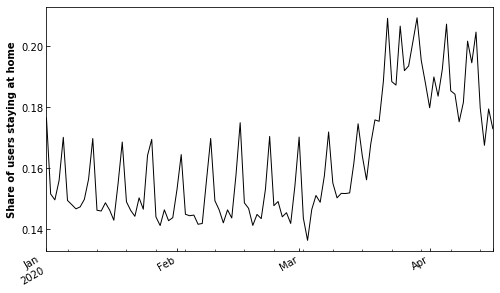

In [13]:
fig,ax=plt.subplots(figsize=(8,5))

pct_home_date.truncate(after=end_date).plot(
ax=ax,linewidth=1,color='k')
ax.locator_params(axis='y',nbins=6)
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('Share of users staying at home',fontweight='bold')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-users-staying-at-home.pdf'),bbox_inches='tight')

# Neighborhood visits

In [14]:
print('Import Parquet Files')
start = timer()

data_dirs=glob(os.path.join(path_to_data,source,'processed',country,'pings_geocoded','*'))
pings_geocoded = pd.concat(
    pd.read_parquet(parquet_file)
    for data_dir in data_dirs for parquet_file in Path(data_dir).glob('*.parquet')
)

print("Done in", round(timer()-start), "sec")  

Import Parquet Files
Done in 86 sec


In [15]:
print('Process')
start = timer()

pings_geocoded['date']=pings_geocoded.time.dt.date
pings_geocoded['hour']=pings_geocoded.time.dt.hour

print("Done in", round(timer()-start), "sec")  

Process
Done in 86 sec


In [16]:
print('Count Neighborhood Visits')
start = timer()

n_admin_date_id=pings_geocoded.groupby(['date','cuebiq_id'])['ADM4_PCODE'].agg(['nunique','count'])
n_admin_daytime_id=pings_geocoded[pings_geocoded.hour.isin(day)].groupby(['date','cuebiq_id'])['ADM4_PCODE'].agg(['nunique','count'])
n_admin_nighttime_id=pings_geocoded[pings_geocoded.hour.isin(night)].groupby(['date','cuebiq_id'])['ADM4_PCODE'].agg(['nunique','count'])

print("Done in", round(timer()-start), "sec")

Count Neighborhood Visits
Done in 854 sec


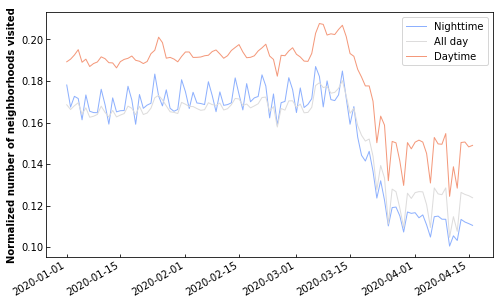

In [17]:
fig,ax=plt.subplots(figsize=(8,5))

for i,(data,label) in enumerate(zip([n_admin_nighttime_id,n_admin_date_id,n_admin_daytime_id,],
                                    ['Nighttime','All day','Daytime'])):
    
    data[data['count']>20]['nunique'].divide(data[data['count']>20]['count']).groupby('date').mean().truncate(
    before=pd.to_datetime(start_date),after=pd.to_datetime(end_date)).plot(
    ax=ax,linewidth=1,color=sns.color_palette("coolwarm", 3)[i],label=label)

ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=7)
ax.set_xlabel('')
ax.set_ylabel('Normalized number of neighborhoods visited',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'number-of-neighborhoods-visited.pdf'),bbox_inches='tight')

# Demographics

In [18]:
print('Import admin data')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Import admin data
Done in 62 sec


In [19]:
print('Merge admin and home data')
start = timer()

primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'

geocoded_home=gpd.sjoin(primary_home[['cuebiq_id','geometry']],admin,op='intersects')
geocoded_home=geocoded_home.merge(admin2city,on=admin_id,how='left')
geocoded_home['population_density']=geocoded_home['total_population'].divide(geocoded_home['a_km2'])

for col in demographics:
    print(col)
    geocoded_home[col+'_quantile']=pd.qcut(geocoded_home[col],2,range(1,3))
    
print("Done in", round(timer()-start), "sec")  

Merge admin and home data
wealth_index
population_density
Done in 20 sec


# Home Presence by Demographic Groups

In [20]:
n_pings_home_id_date_demog=n_pings_home_id_date.drop(['n_home','n_pings'],1).reset_index().merge(
geocoded_home[['cuebiq_id',city_id]+[x+'_quantile' for x in demographics]],on=['cuebiq_id'])

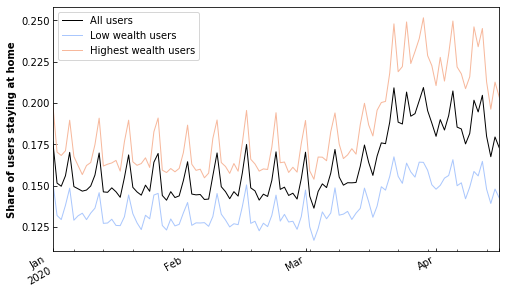

In [21]:
fig,ax=plt.subplots(figsize=(8,5))

pct_home_date_demog=n_pings_home_id_date_demog.groupby(['wealth_index_quantile','date'])['pct_home'].apply(
lambda x:(x==1).sum()/x.count())

pct_home_date.truncate(after=end_date).plot(ax=ax,linewidth=1,color='k',label='All users')

for i,(val,name) in enumerate(zip([1,2],['Low wealth users','Highest wealth users'])):
    pct_home_date_demog.loc[val].plot(
    ax=ax,linewidth=1,color=sns.color_palette("coolwarm", 2)[i],label=name)
    
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Share of users staying at home',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-users-staying-at-home-by-wealth.pdf'),bbox_inches='tight')

In [22]:
top_3_cities=geocoded_home.UC_NM_MN.value_counts().index[:3]

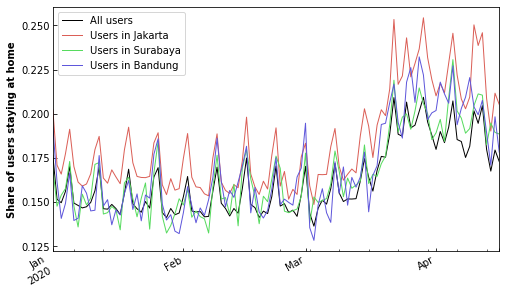

In [23]:
fig,ax=plt.subplots(figsize=(8,5))

pct_home_date_demog=n_pings_home_id_date_demog.groupby(['UC_NM_MN','date'])['pct_home'].apply(
lambda x:(x==1).sum()/x.count())

pct_home_date.plot(ax=ax,linewidth=1,color='k',label='All users')

for i,name in enumerate(top_3_cities):
    pct_home_date_demog.loc[name].plot(
    ax=ax,linewidth=1,color=sns.color_palette("hls", len(top_3_cities))[i],label='Users in '+name)
    
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Share of users staying at home',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'share-of-users-staying-at-home-by-city.pdf'),bbox_inches='tight')

# Neighborhood Visits by Demographic Groups

In [24]:
n_admin_date_id_demog=n_admin_date_id.reset_index().merge(geocoded_home,on='cuebiq_id')

In [25]:
n_admin_date_demog=n_admin_date_id_demog.groupby(['wealth_index_quantile','date']).apply(
lambda x:(x['nunique']/x['count']).mean())

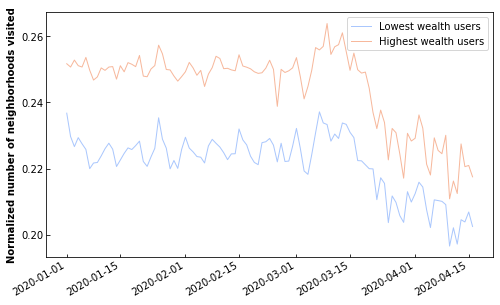

In [26]:
fig,ax=plt.subplots(figsize=(8,5))

for i,(val,name) in enumerate(zip([1,2],['Lowest wealth users','Highest wealth users'])):
    n_admin_date_demog.loc[val].truncate(before=pd.to_datetime(start_date),after=pd.to_datetime(end_date)).plot(
    ax=ax,linewidth=1,color=sns.color_palette("coolwarm", 2)[i],label=name)

ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Normalized number of neighborhoods visited',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'number-of-neighborhoods-visited-by-wealth.pdf'),bbox_inches='tight')

In [27]:
n_admin_date_demog=n_admin_date_id_demog.groupby([city_id,'date']).apply(
lambda x:(x['nunique']/x['count']).mean())

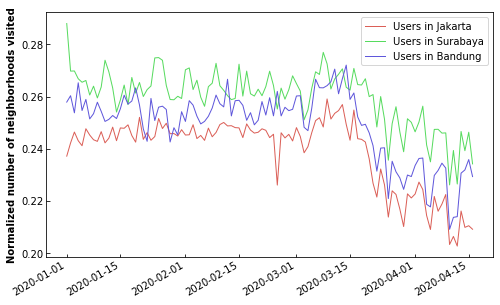

In [28]:
fig,ax=plt.subplots(figsize=(8,5))

for i,name in enumerate(top_3_cities):
    n_admin_date_demog.loc[name].truncate(before=pd.to_datetime(start_date),after=pd.to_datetime(end_date)).plot(
    ax=ax,linewidth=1,color=sns.color_palette("hls", len(top_3_cities))[i],label='Users in '+name)

ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=6)
ax.set_xlabel('')
ax.set_ylabel('Normalized number of neighborhoods visited',fontweight='bold')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'neighborhoods-visited-by-age.pdf'),bbox_inches='tight')